# A6. Transformers: Movie Analysis & Recommender System

### Swathi Banna

#### Dataset: Movies_27K_Reviews (27,000 reviews)
#### Sentiment analyses of critic_line and audience_review:
1. Text embeddings and transformers
2. NLTK Vader
3. Textblob
#### Recommender system
Five recommendations by comparing that input with:
1. Critic_line
2. Audience_review

In [43]:
import numpy as np
import pandas as pd
import pickle

In [157]:
movies = pd.read_csv(r"C:\Users\Swathi\Documents\BAIS\Text Analytics\Assignments\A6 Transformers\Movies_27K_Reviews.csv")

In [158]:
movies.shape

(26811, 18)

In [4]:
movies.head()

,Rating:,Genre:,Directed By:,Written By:,In Theaters:,On Disc/Streaming:,Runtime:,Studio:,movie_name,critic_consensus,critic_score,audience_score,top_5_celeb_names,critic_line,critic_url,audience_review,quotes,Box Office:
0,PG-13 (for sequences of violence),"Action & Adventure, Drama, Kids & Family",Niki Caro,"Rick Jaffa, Amanda Silver, Elizabeth Martin, L...","Aug 21, 2020 wide","Sep 4, 2020",115 minutes,Disney+,Mulan,It could have told its classic story with grea...,75%,51%,"yifei-liu, donnie_yen, jason_scott_lee, yoson_...","I'm as athletic as a bed sock but, for so many...",https://www.standard.co.uk/go/london/film/mula...,The new Mulan looked like something I've been ...,NaN,NaN
1,PG-13 (for some language),"Action & Adventure, Comedy, Science Fiction & ...",Dean Parisot,"Chris Matheson, Ed Solomon","Aug 28, 2020 wide","Aug 28, 2020",NaN,Orion Pictures,Bill & Ted Face the Music,"As wholesomely goofy as its heroes, Bill and T...",81%,75%,"keanu_reeves, alex_winter, samara_weaving, bri...","For fans, the pair's all-round lameness has al...",https://www.smh.com.au/culture/movies/bill-and...,Bill & Ted Face the Music is one of those rare...,NaN,NaN
2,NR,Documentary,Gustavo Sanchez,Gustavo Sanchez,NaN,"Sep 1, 2020",75 minutes,Media Luna Films,I Hate New York,NaN,100%,NaN,"bibbe_hansen, amanda_lepore, chloe_dzubilo, so...",NaN,NaN,NaN,NaN,NaN
3,"R (for drug content, language throughout inclu...","Action & Adventure, Comedy, Horror",Ninian Doff,Ninian Doff,NaN,"Aug 28, 2020",86 minutes,Amazon Studios,Get Duked!,The rare comedy thriller that's funny as well ...,86%,62%,"samuel_bottomley, rian_gordon, lewis_gribben, ...",Doff announces himself as a talent to be recko...,"https://www.reelviews.net/reelviews/get-duked,...",NaN,NaN,NaN
4,NR,"Drama, Gay & Lesbian",Flavio Alves,"John Rotondo, Flavio Alves","Aug 28, 2020 limited","Sep 8, 2020",88 minutes,Uncork'd Entertainment,The Garden Left Behind,The Garden Left Behind draws on one immigrant'...,92%,94%,"michael_madsen, edward_asner, carlie_guevara, ...",NaN,NaN,NaN,NaN,NaN


## Preprocessing

In [5]:
# Selecting relevant columns

movies = movies[['movie_name','critic_line','audience_review']]

In [6]:
movies.head()

,movie_name,critic_line,audience_review
0,Mulan,"I'm as athletic as a bed sock but, for so many...",The new Mulan looked like something I've been ...
1,Bill & Ted Face the Music,"For fans, the pair's all-round lameness has al...",Bill & Ted Face the Music is one of those rare...
2,I Hate New York,NaN,NaN
3,Get Duked!,Doff announces himself as a talent to be recko...,NaN
4,The Garden Left Behind,NaN,NaN


In [7]:
movies.isna().sum()

movie_name            0
critic_line        9023
audience_review    8274
dtype: int64

In [8]:
# Removing rows with null values

movies = movies[pd.notnull(movies['critic_line'])]
movies = movies[pd.notnull(movies['audience_review'])]

In [9]:
movies.isna().sum()

movie_name         0
critic_line        0
audience_review    0
dtype: int64

In [10]:
movies.shape

(14068, 3)

Out of 26811 samples, we are left with 14068 samples after removing the null values from critic_line and audience_review.

In [152]:
import re

In [12]:
# Removing unnecessary terms from "critic_line" column : Full Review, Rating, Date

regex1 = r'Full Review…,*'
regex2 = 'Rating: \d+(\.\d+)?\/\d+'      
regex3 = r'\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},\s+\d{4}\b'

movies['critic_line'] = movies['critic_line'].str.replace(regex1, '', regex=True)
movies['critic_line'] = movies['critic_line'].str.replace(regex2, '', regex=True)
movies['critic_line'] = movies['critic_line'].str.replace(regex3, '', regex=True)
movies['critic_line'] = movies['critic_line'].str.replace('|', '')

## Text embeddings and Transformers

In [86]:
from transformers import pipeline

In [120]:
# Using the default model: distilbert

trf_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

In [121]:
movies['trf_crit'] = movies['critic_line'].apply(lambda x: trf_pipeline(x[:512])[0]['label'])

In [127]:
movies['trf_aud'] = movies['audience_review'].apply(lambda x: trf_pipeline(x[:512])[0]['label'])

## NLTK Vader

In [90]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [36]:
# Sentiment analysis of 'critic_line'.
# Classifying the reviews into Positive, Negative or Neutral, based on the 'compound' value.

movies['vdr_crit'] = movies['critic_line'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
movies['senti_vdr_crit'] = movies['vdr_crit'].apply(lambda x: 'positive' \
                                    if x >= 0.5 else ('negative' if x <= -0.5 else 'neutral'))

In [37]:
# Sentiment analysis of 'audience_review'.
# Classifying the reviews into Positive, Negative or Neutral, based on the 'compound' value.

movies['vdr_aud'] = movies['audience_review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
movies['senti_vdr_aud'] = movies['vdr_aud'].apply(lambda x: 'positive' \
                                    if x >= 0.5 else ('negative' if x <= -0.5 else 'neutral'))

## Textblob

In [91]:
from textblob import TextBlob

In [39]:
movies['blob_crit'] = movies['critic_line'].apply(lambda x: TextBlob(x).sentiment.polarity)
movies['senti_blob_crit'] = movies['blob_crit'].apply(lambda x: 'positive' \
                                    if x >= 0.5 else ('negative' if x <= -0.5 else 'neutral'))

In [40]:
movies['blob_aud'] = movies['audience_review'].apply(lambda x: TextBlob(x).sentiment.polarity)
movies['senti_blob_aud'] = movies['blob_aud'].apply(lambda x: 'positive' \
                                    if x >= 0.5 else ('negative' if x <= -0.5 else 'neutral'))

In [41]:
# Saving the movies dataframe in a pickle file

with open('movies_pkl', 'wb') as pkl_file:
    pickle.dump(movies, pkl_file)

In [44]:
with open('movies_pkl', 'rb') as pkl_file:
    movies = pickle.load(pkl_file)

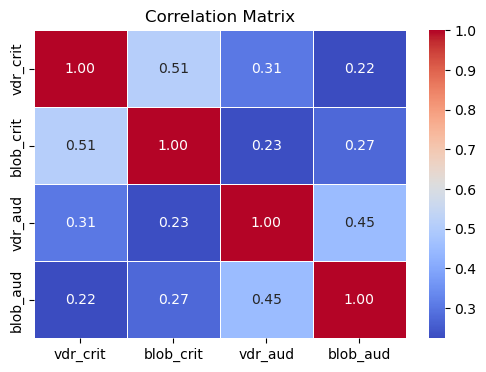

In [140]:
# Comparing the scores of NLTK Vader and Text Blob with a correlation matrix

from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

scores = movies[['vdr_crit','blob_crit','vdr_aud','blob_aud']]

plt.figure(figsize=(6, 4))
sns.heatmap(scores.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

#### The correlation matrix shows that scoring using NLTK Vader is not very similar to Text blob.

### Testing Sentiment Analysis with Out-of-sample reviews

In [147]:
reviews_data = {
    'Review Text': ["I thoroughly enjoyed 'The Great Adventure'. The acting was superb, especially by the lead actor. The storyline kept me engaged throughout the entire movie.",
                    "Unfortunately, 'Lost in Time' did not meet my expectations. The plot felt disjointed, and the characters lacked depth. Overall, a disappointing experience.",
                    "I was mesmerized by the breathtaking cinematography in 'Cinematic Beauty'. Each frame was like a work of art, adding to the immersive experience of the film.",
                    "'Love in Paris' is a true masterpiece. The emotional depth of the characters and the poignant storyline left a lasting impact on me. A must-watch for any romantic.",
                    "I regret spending my time on 'The Last Stand'. The acting was wooden, and the dialogue felt forced. Overall, a forgettable experience.",
                    "'Mystery Island' had its moments, but the plot lacked coherence. The twists and turns felt contrived, making it difficult to fully immerse myself in the story.",
                    "Wow! 'The Epic Journey' exceeded all my expectations. From the gripping storyline to the stellar performances, this movie had it all. A cinematic gem!",
                    "Unfortunately, 'Beyond the Stars' was not my cup of tea. The slow pacing and lack of character development made it difficult to stay engaged. Overall, a dull experience.",
                    "'Thrill Seeker' kept me on the edge of my seat from start to finish. The adrenaline-pumping action sequences and unexpected twists made it a thrilling ride.",
                    "I was disappointed by 'Dreamscape'. Despite the hype, the film fell flat with its predictable plot and uninspired performances."],
    'Label':["Positive","Negative","Positive","Positive","Negative","Negative","Positive","Negative","Positive","Negative"]

}

reviews_df = pd.DataFrame(reviews_data)

In [153]:
# Using the three approaches to verify the sample data

reviews_df['trf_crit'] = reviews_df['Review Text'].apply(lambda x: trf_pipeline(x[:512])[0]['label'])


reviews_df['vdr_crit'] = reviews_df['Review Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
reviews_df['senti_vdr_crit'] = reviews_df['vdr_crit'].apply(lambda x: 'positive' \
                                    if x >= 0.5 else ('negative' if x <= -0.5 else 'neutral'))

reviews_df['blob_crit'] = reviews_df['Review Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
reviews_df['senti_blob_crit'] = reviews_df['blob_crit'].apply(lambda x: 'positive' \
                                    if x >= 0.5 else ('negative' if x <= -0.5 else 'neutral'))

In [154]:
pd.set_option('display.max_colwidth', None)

In [155]:
reviews_df[['Review Text','Label','trf_crit','senti_vdr_crit','senti_blob_aud']]

,Review Text,Label,trf_crit,senti_vdr_crit,senti_blob_aud
0,"I thoroughly enjoyed 'The Great Adventure'. The acting was superb, especially by the lead actor. The storyline kept me engaged throughout the entire movie.",Positive,POSITIVE,positive,neutral
1,"Unfortunately, 'Lost in Time' did not meet my expectations. The plot felt disjointed, and the characters lacked depth. Overall, a disappointing experience.",Negative,NEGATIVE,negative,neutral
2,"I was mesmerized by the breathtaking cinematography in 'Cinematic Beauty'. Each frame was like a work of art, adding to the immersive experience of the film.",Positive,POSITIVE,positive,positive
3,'Love in Paris' is a true masterpiece. The emotional depth of the characters and the poignant storyline left a lasting impact on me. A must-watch for any romantic.,Positive,POSITIVE,positive,neutral
4,"I regret spending my time on 'The Last Stand'. The acting was wooden, and the dialogue felt forced. Overall, a forgettable experience.",Negative,NEGATIVE,negative,neutral
5,"'Mystery Island' had its moments, but the plot lacked coherence. The twists and turns felt contrived, making it difficult to fully immerse myself in the story.",Negative,NEGATIVE,negative,negative
6,"Wow! 'The Epic Journey' exceeded all my expectations. From the gripping storyline to the stellar performances, this movie had it all. A cinematic gem!",Positive,POSITIVE,positive,neutral
7,"Unfortunately, 'Beyond the Stars' was not my cup of tea. The slow pacing and lack of character development made it difficult to stay engaged. Overall, a dull experience.",Negative,NEGATIVE,negative,neutral
8,'Thrill Seeker' kept me on the edge of my seat from start to finish. The adrenaline-pumping action sequences and unexpected twists made it a thrilling ride.,Positive,POSITIVE,positive,neutral
9,"I was disappointed by 'Dreamscape'. Despite the hype, the film fell flat with its predictable plot and uninspired performances.",Negative,NEGATIVE,neutral,neutral


#### Out of 10 samples, the following are correct:

Transformers: 10/10 </br>
NLTK Vader: 9/10 </br>
Text Blob: 2/10 </br>
#### So, Transformers and NLTK Vader performed the best. Text Blob did not perform well.

## Recommender System

In [23]:
movies.reset_index(drop=True, inplace=True)

In [24]:
from sentence_transformers import SentenceTransformer, util

In [25]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [26]:
def generate_embeddings(text):
    response = model.encode(text)
    return response.tolist()

In [28]:
embeddings_crit = generate_embeddings(movies['critic_line'])

In [29]:
embeddings_aud = generate_embeddings(movies['audience_review'])

In [31]:
# Embedding list for Critics reviews

embedding_list_crit = [x for x in embeddings_crit]

column_names = ["embedding_" + str(i) for i in range(len(embedding_list_crit[0]))]
critics_train = pd.DataFrame(embedding_list_crit, columns=column_names)
critics_train.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_374,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383
0,-0.086359,0.003585,0.060400,0.058468,-0.045365,-0.003481,0.076538,-0.021598,-0.004627,-0.007296,...,0.067561,0.016058,-0.089154,0.070001,-0.035854,0.069387,0.060789,-0.054699,-0.058071,0.034461
1,-0.075804,-0.033454,0.015800,-0.061079,-0.011763,0.087520,-0.024694,0.019606,0.046784,-0.024351,...,0.032810,-0.055702,-0.103533,0.109823,-0.019812,-0.002771,-0.033957,-0.052593,0.037143,-0.040273
2,0.034234,0.012760,0.023324,-0.063550,0.024627,0.116004,0.006998,-0.072486,0.031058,-0.012616,...,0.006742,0.054875,-0.038083,0.111616,-0.001524,-0.035537,-0.034020,0.028608,-0.044559,-0.088794
3,-0.059682,-0.007943,0.038947,-0.026314,0.050569,0.050527,0.007398,0.051933,-0.019672,-0.062470,...,0.039429,-0.002836,-0.076184,0.075749,-0.070931,0.072887,0.019842,-0.010270,0.006983,0.002417
4,-0.045368,-0.093963,0.064420,0.079947,-0.033514,0.031448,0.059675,-0.001352,0.017862,0.046056,...,0.026147,-0.049838,0.006603,0.033152,0.003512,0.048851,0.107524,-0.063687,-0.032070,-0.075618


In [32]:
# Embedding list for Audience reviews

embedding_list_aud = [x for x in embeddings_aud]

aud_train = pd.DataFrame(embedding_list_aud, columns=column_names)
aud_train.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_374,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383
0,-0.105715,-0.014010,0.059994,-0.020713,0.023589,-0.061019,-0.046433,0.031357,0.027580,0.003200,...,0.043500,0.018432,0.006391,0.107987,-0.027069,0.052649,0.121764,-0.115233,-0.004676,0.103778
1,-0.069129,-0.059104,0.053235,-0.039038,-0.021591,0.040568,-0.063707,-0.014349,0.024259,-0.021900,...,0.054087,0.003524,-0.100524,0.114169,-0.096863,-0.014301,0.061938,0.018921,0.103297,0.050647
2,-0.029579,-0.063403,-0.016509,0.011005,-0.055286,0.065524,0.053699,-0.074546,-0.022276,-0.046347,...,-0.034004,0.017763,-0.034289,0.081735,0.050489,0.041316,0.061257,-0.023832,-0.031289,-0.064351
3,-0.053783,-0.071589,0.050645,-0.042002,0.036211,-0.014852,0.076970,0.015619,0.042098,-0.013284,...,0.001516,-0.032991,-0.052267,0.038650,-0.057919,0.013483,-0.014507,-0.016940,-0.010638,0.016357
4,-0.050016,-0.022692,-0.003875,-0.059385,0.006158,0.037592,-0.022677,0.016427,0.050472,-0.052651,...,-0.036867,0.001111,-0.042878,-0.010019,-0.022769,0.098614,0.074003,0.043791,-0.031906,0.039396


In [33]:
# Create target variable for classification

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(movies['movie_name'])

critics_train['label'] = labels
aud_train['label'] = labels

In [48]:
# Saving the embedded files as pickle files

with open('embeddings_crit_pkl', 'wb') as pkl_file:
    pickle.dump(embeddings_crit, pkl_file)
with open('embeddings_aud_pkl', 'wb') as pkl_file:
    pickle.dump(embeddings_aud, pkl_file)
with open('critics_train_pkl', 'wb') as pkl_file:
    pickle.dump(critics_train, pkl_file)
with open('aud_train_pkl', 'wb') as pkl_file:
    pickle.dump(aud_train, pkl_file)

In [49]:
with open('embeddings_crit_pkl', 'rb') as pkl_file:
    embeddings_crit = pickle.load(pkl_file)
with open('embeddings_aud_pkl', 'rb') as pkl_file:
    embeddings_aud = pickle.load(pkl_file)
with open('critics_train_pkl', 'rb') as pkl_file:
    critics_train = pickle.load(pkl_file)
with open('aud_train_pkl', 'rb') as pkl_file:
    aud_train = pickle.load(pkl_file)

### Five recommendations based on Critics and Audience reviews

In [36]:
user_input = input("What kind of movies do you like to watch: ")

What kind of movies do you like to watch: i wish to watch a comedy movie


In [37]:
embeddings_sample = model.encode(user_input)

In [38]:
from sklearn.neighbors import DistanceMetric

In [40]:
dist = DistanceMetric.get_metric('euclidean')

distances_crit = dist.pairwise(embedding_list_crit, embeddings_sample.reshape(1, -1)).flatten()
distances_aud = dist.pairwise(embedding_list_aud, embeddings_sample.reshape(1, -1)).flatten()

# Sort results
distances_sorted_crit = np.argsort(distances_crit)
distances_sorted_aud = np.argsort(distances_aud)

In [50]:
print("As per Critics reviews:")
printed_movies = set()
for movie, distance in zip(movies['movie_name'].iloc[distances_sorted_crit[:15]][::-1], distances_crit[distances_sorted_crit[:15]][::-1]):
    if movie not in printed_movies:
        print(f"{movie}: {distance}")
        printed_movies.add(movie)

print("\nAs per Audience reviews:")
printed_movies = set()
for movie, distance in zip(movies['movie_name'].iloc[distances_sorted_aud[:15]][::-1], distances_aud[distances_sorted_aud[:15]][::-1]):
    if movie not in printed_movies:
        print(f"{movie}: {distance}")
        printed_movies.add(movie)

As per Critics reviews:
Strange Wilderness: 1.0018504889687643
The FP: 0.9976905932456591
The Slammin' Salmon: 0.9971642461752398
Epic Movie: 0.9896801172612203
Mystery Team: 0.9847309234105074
The Dilemma: 0.9632014573904338

As per Audience reviews:
Yes Man: 0.9884766988082414
Ishtar: 0.9802607749597159
Marriage Story: 0.9786223095918191
Hot Tub Time Machine: 0.9696901732041616
We're The Millers: 0.9509871051226306
Epic Movie: 0.9463685415196524
Code Name: The Cleaner: 0.9450786250001323


#### The genres of the above movies as per ChatGPT:

Critics' Reviews:</br>

Strange Wilderness: Adventure, Comedy </br>
The FP: Action, Comedy </br>
The Slammin' Salmon: Comedy </br>
Epic Movie: Adventure, Comedy </br>
Mystery Team: Comedy, Mystery </br>
The Dilemma: Comedy, Drama </br>

Audience Reviews:

Yes Man: Comedy, Romance </br>
Ishtar: Adventure, Comedy </br>
Marriage Story: Comedy, Drama, Romance </br>
Hot Tub Time Machine: Comedy, Sci-Fi </br>
We're The Millers: Comedy, Crime </br>
Epic Movie: Adventure, Comedy </br>
Code Name: The Cleaner: Action, Comedy </br>

#### All the movies listed in both Critic and Audience reviews belong to Comedy genre, as was asked for, in the user input.

### Out of sample data

In [53]:
data = {
    "Input": [
        "I enjoy action-packed movies with lots of explosions and thrilling chase scenes.",
        "I prefer heartwarming romantic comedies that make me laugh and feel good.",
        "I'm a fan of sci-fi films that explore complex futuristic worlds and advanced technology.",
        "I love horror movies that keep me on the edge of my seat, filled with suspense and scares.",
        "I enjoy watching historical dramas that transport me to different time periods and cultures.",
        "I like documentaries that delve into real-life stories and provide thought-provoking insights.",
        "I'm into fantasy movies with magical creatures, epic battles, and imaginative worlds.",
        "I'm a big fan of animated films, especially those with intricate animation and engaging storytelling.",
        "I prefer thought-provoking indie films that challenge conventional storytelling and tackle deep themes.",
        "I enjoy watching classic films from the golden age of cinema, timeless stories with great performances."
    ]
}
sample_data = pd.DataFrame(data)

In [54]:
pd.set_option('display.max_colwidth', None)

In [156]:
for i in range(len(sample_data)):
    embeddings_sample = model.encode(sample_data.iloc[i,0])
    distances_crit = dist.pairwise(embedding_list_crit, embeddings_sample.reshape(1, -1)).flatten()
    distances_aud = dist.pairwise(embedding_list_aud, embeddings_sample.reshape(1, -1)).flatten()

    distances_sorted_crit = np.argsort(distances_crit)
    distances_sorted_aud = np.argsort(distances_aud)
    
    bold = "\033[1m"
    red = "\033[31m"
    black = "\033[30m"
    reset = "\033[0m"
    
    print("\n\n" + bold + red, i+1, "-",sample_data.iloc[i].values[0],"\n-----------------------------------------------------------------" + bold + red)
    print(bold + black, "Critics' Picks:", reset)
    printed_movies = set()
    for movie, distance in zip(movies['movie_name'].iloc[distances_sorted_crit[:15]][::-1], distances_crit[distances_sorted_crit[:15]][::-1]):
        if movie not in printed_movies:
            print(f"{movie}: {round(distance,2)}")
            printed_movies.add(movie)

    print(bold + black, "Audience Favorites:", reset)
    printed_movies = set()
    for movie, distance in zip(movies['movie_name'].iloc[distances_sorted_aud[:15]][::-1], distances_aud[distances_sorted_aud[:15]][::-1]):
        if movie not in printed_movies:
            print(f"{movie}: {round(distance,2)}")
            printed_movies.add(movie)



 1 - I enjoy action-packed movies with lots of explosions and thrilling chase scenes. 
-----------------------------------------------------------------
 Critics' Picks: 
Knight & Day: 1.0
24 Hours to Live: 0.99
Mission: Impossible Ghost Protocol: 0.98
Braven: 0.98
Prince of Persia: The Sands of Time: 0.97
 Audience Favorites: 
The Perfect Guy: 0.97
Snabba cash (Easy Money): 0.97
Killshot: 0.95
Night of the Creeps: 0.95
Special Forces: 0.94
Same Kind of Different As Me: 0.93


 2 - I prefer heartwarming romantic comedies that make me laugh and feel good. 
-----------------------------------------------------------------
 Critics' Picks: 
La princesse de Montpensier (The Princess of Montpensier): 0.96
Rough Night: 0.96
The Five-Year Engagement: 0.95
Think Like a Man: 0.93
Romantics Anonymous: 0.93
 Audience Favorites: 
Examined Life: 0.98
Back to Burgundy (Ce qui nous lie): 0.97
Maggie's Plan: 0.96
One Day: 0.93
The Five-Year Engagement: 0.83


 3 - I'm a fan of sci-fi films that expl

#### In most of the cases, movie recommendations based on both critics' reviews and audience reviews gave correct recommendations. So, we can say that the model is working fine.